In [104]:
import os, utils
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from model.modelmlp import ModelMLP
from tqdm import tqdm
from losses.losses import ssm_loss


sns.set(style="dark")
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [2]:
a = 1
s1 = 2
s2 = 3

num_samples = 1000000

x1 = np.random.normal(a, s1, size=num_samples)
x2 = np.random.normal(0, s2, size=num_samples)

x_sigma_add = np.random.normal(a, s2, size=num_samples)
x_gauss_add = np.random.normal(a, np.sqrt(s1**2+s2**2), size=num_samples)
x_sum = x1 + x2

In [3]:
print("x_sum:", np.mean(x_sum), np.std(x_sum))
print("x_sigma_add:", np.mean(x_sigma_add), np.std(x_sigma_add))
print("x_gauss_add:", np.mean(x_gauss_add), np.std(x_gauss_add))

x_sum: 0.9960707275973596 3.6105081558203564
x_sigma_add: 1.000563946013736 2.999309715907416
x_gauss_add: 1.0022001141788606 3.602631312084817


In [4]:
a, np.sqrt(s1**2 + s2**2)

(1, 3.605551275463989)

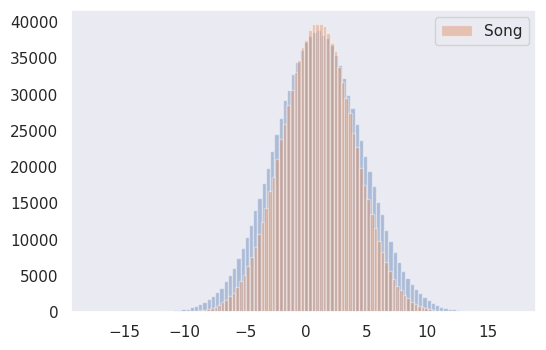

In [5]:
sns.distplot(x_sum, kde=False, bins=100)
sns.distplot(x_sigma_add, label="Song", kde=False, bins=100)
plt.legend()

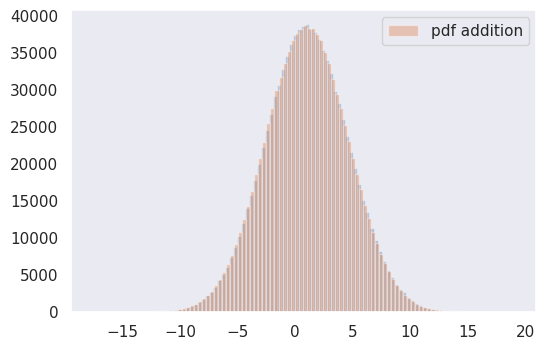

In [6]:
sns.distplot(x_sum, kde=False, bins=100)
sns.distplot(x_gauss_add, label="pdf addition", kde=False, bins=100)
plt.legend()

In [7]:

tfd = tfp.distributions

def GMM(probs, loc, scale):
    gmm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=probs),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=loc,
            scale_identity_multiplier=scale))
    return gmm


def meshgrid(x):
    y = x
    [gx, gy] = np.meshgrid(x, y, indexing='ij')
    gx, gy = np.float32(gx), np.float32(gy)
    grid = np.concatenate([gx.ravel()[None, :], gy.ravel()[None, :]], axis=0)
    return grid.T.reshape(x.size, y.size, 2)


def visualize_density(gmm, x):
    grid = meshgrid(x)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(gmm.prob(grid), cmap='inferno', extent=[-12, 12, -12, 12], origin='lower')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
#     plt.savefig("density.pdf", bbox_inches="tight")
    plt.show()
    return


def sample(gmm, nr_samples):
    s = tfd.Sample(gmm, sample_shape=nr_samples)
    return s.sample()


def visualize_samples(samples, filename="samples"):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(samples.numpy()[:, 0], samples.numpy()[:, 1], marker='.', color="black")
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
#     ax.set_xlim(-10, 10)
#     ax.set_ylim(-10, 10)
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    return

def visualize_gradients(x, grads, filename="gradients"):
    U, V = grads[:, :, 1], grads[:, :, 0]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.quiver(x, x, U, V)
    plt.gca().set_aspect('equal', adjustable='box')     
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.show()


def estimated_log_prob_grad(gmm, x_for_grads, batch_size=128, iterations=10000, ):
    trained_model = train(gmm, batch_size, iterations)
    est_grads = trained_model(meshgrid(x_for_grads))
    return est_grads


def train(gmm, batch_size, total_steps):
    device = utils.get_tensorflow_device()

    # split data into batches
    model = ModelMLP(activation=tf.nn.softplus)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    step = 0
    progress_bar = tqdm(range(total_steps))
    progress_bar.set_description(f'iteration {step}/{total_steps} | current loss ?')

    with tf.device(device):  # For some reason, this makes everything faster
        avg_loss = 0
        for _ in progress_bar:
            data_batch = sample(gmm, batch_size)
            step += 1

            with tf.GradientTape(persistent=True) as t:
                current_loss = ssm_loss(model, data_batch)
                gradients = t.gradient(current_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            tf.summary.scalar('loss', float(current_loss), step=int(step))

            progress_bar.set_description(f'iteration {step}/{total_steps} | current loss {current_loss:.3f}')

            avg_loss += current_loss
            if step == total_steps:
                return model


@tf.function
def langevin_dynamics(grad_function, gmm, x, sigma_i=None, alpha=0.1, T=1000):
    for t in range(T):
        score = grad_function(gmm, x, sigma_i)
        noise = tf.sqrt(alpha) * tf.random.normal(shape=x.get_shape(), mean=0, stddev=1.0)
        x = x + (alpha / 2) * score + noise
    return x


def annealed_langevin_dynamics(grad_function, gmm, x, sigmas, eps=0.1, T=100):
    for i, sigma_i in enumerate(sigmas):
        alpha_i = eps * (sigma_i ** 2) / (sigmas[-1] ** 2)
        x = langevin_dynamics(grad_function, gmm, x, sigma_i=sigma_i, alpha=alpha_i, T=T)
    return x

In [9]:
# @tf.function
def analytic_log_prob_grad(gmm, x, sigma_i=None):
    x_tensor = tf.convert_to_tensor(x)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        if sigma_i is None:
            log_prob = tf.reduce_sum(gmm.log_prob(x_tensor))
        else:
            sigma_i = tf.math.sqrt(sigma_i**2 + 1)
            # params_dist_1 = gmm.components_distribution[0].parameters
            # params_dist_2 = gmm.components_distribution[1].parameters
            # mix_probs = gmm.mixture_distribution.probs
            normal1 = tfd.MultivariateNormalDiag(loc=[-5, -5],
                                                 scale_diag=[[sigma_i, sigma_i]])
            normal2 = tfd.MultivariateNormalDiag(loc=[5, 5],
                                                 scale_diag=[[sigma_i, sigma_i]])
            probs = list()
            probs.append(tf.math.log(tf.convert_to_tensor(0.2)) + normal1.log_prob(x_tensor))
            probs.append(tf.math.log(tf.convert_to_tensor(0.8)) + normal2.log_prob(x_tensor))

            log_prob = tf.reduce_logsumexp(tf.stack(probs, axis=0), axis=0)
    anal_gradients = t.gradient(log_prob, x_tensor)
    return anal_gradients

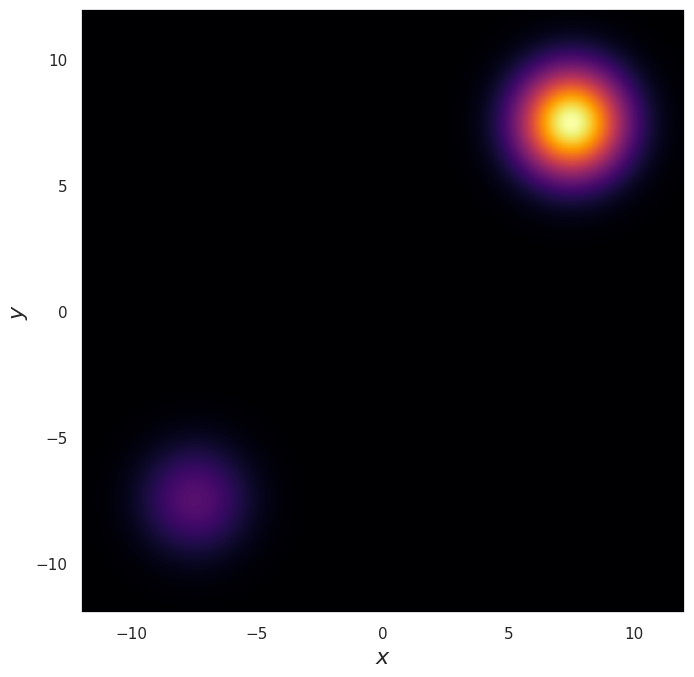

In [10]:
# create a GMM (probabilities, cluster centres, cluster scales)
gmm = GMM([0.8, 0.2], [[5, 5], [-5, -5]], [1, 1])

# define grids
x = np.linspace(-8, 8, 500, dtype=np.float32)
x_for_grads = np.linspace(-8, 8, num=20)

# plot density
visualize_density(gmm, x)

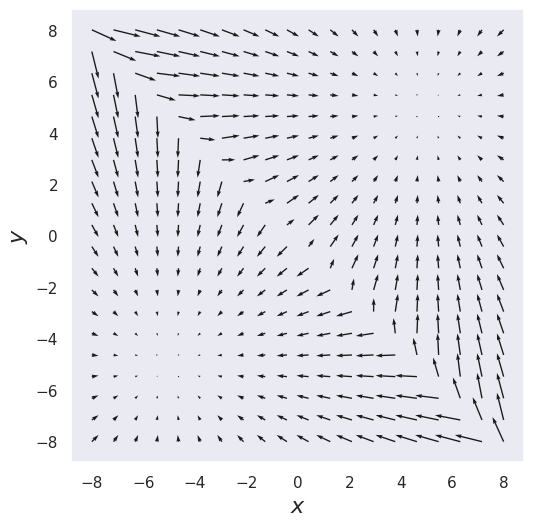

In [11]:
# compute analytic gradients
grid = meshgrid(x_for_grads)
anal_grads = analytic_log_prob_grad(gmm, grid)

# # compute estimated gradients (scores)
# estimated_grads = estimated_log_prob_grad(gmm, x_for_grads)

# visualize gradients
visualize_gradients(x_for_grads, anal_grads, "grad_analytic")
# visualize_gradients(x_for_grads, estimated_grads, "grad_est")

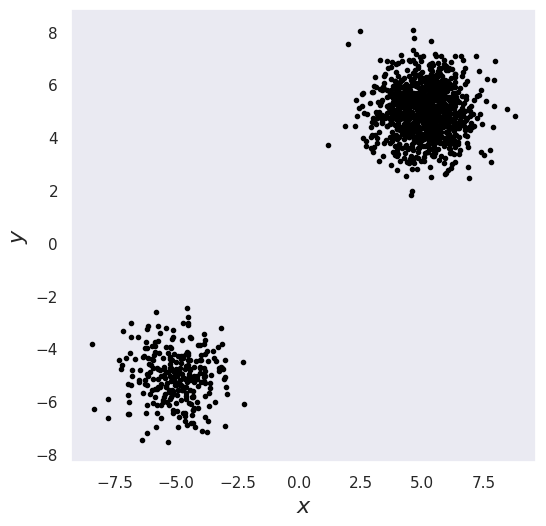

In [12]:
# exact samples from the mixture
true_samples = sample(gmm, 1280)
visualize_samples(true_samples)

In [13]:
x_init = tf.random.uniform(shape=(1280, 2), minval=-8, maxval=8)
sigma_levels = tf.math.exp(tf.linspace(tf.math.log(20.0), 0., 10))

# sigma_levels = tf.clip_by_value(sigma_levels, 0.1, 10.0)
print(sigma_levels)
epsilons =[1e-1]
#
samples = []
#
for epsilon in epsilons:
    print(epsilon)
    samples.append(
        annealed_langevin_dynamics(analytic_log_prob_grad, gmm, x_init, sigma_levels, T=100, eps=epsilon))
#
# # colors = ["#F7D242", "#F89111", "#D24942", "#842069", "#3B0C5C"]
# fig, ax = plt.subplots(1, len(epsilons), sharey=True, figsize=(13, 3))
# #
# for i in range(len(samples)):
#     ax[i].scatter(samples[i].numpy()[:, 0], samples[i].numpy()[:, 1], s=0.5, marker='.', color='black')
# #
# ax[0].set_ylabel(r'$y$')
# ax[0].set_ylim(-10, 10)
# #
# for i, a in enumerate(ax):
#     a.set_aspect('equal', 'box')
#     a.set_xlabel(r'$x$')
#     a.set_xlim(-10, 10)
#     # a.set_ylim(-10, 10)
#     a.set_title(r'$\epsilon=$' + '{0:.0e}'.format(epsilons[i]))

# # plt.savefig("samples_eps_linear_2.pdf", bbox_inches="tight")
# plt.show()

tf.Tensor(
[20.        14.337425  10.278086   7.368063   5.281952   3.7864788
  2.7144175  1.9458873  1.3949506  1.       ], shape=(10,), dtype=float32)
0.1
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


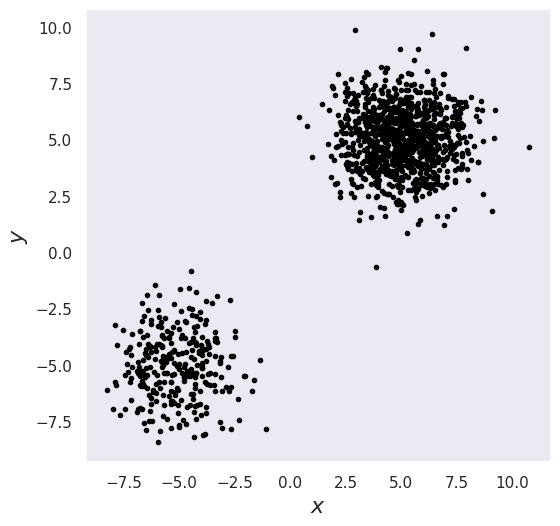

In [14]:
# plot samples
samples_annealed_langevin = samples[0]
visualize_samples(samples_annealed_langevin)

In [9]:
# define grids
x = np.linspace(-8, 8, 500, dtype=np.float32)
x_for_grads = np.linspace(-8, 8, num=20)

## Rotated Gauss

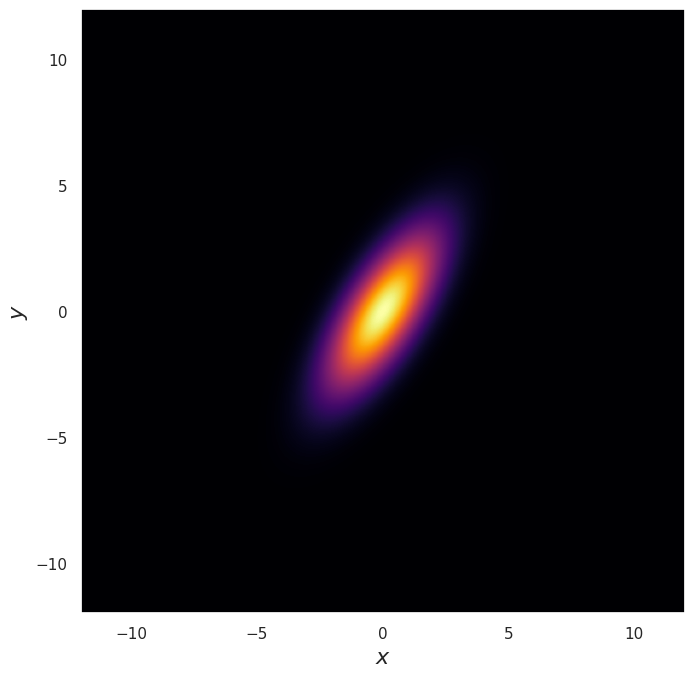

In [10]:
mu = [0,0]
cov = [[2,1],
       [1,1]]

single_gauss = tfd.MultivariateNormalFullCovariance(
    loc=mu,
    covariance_matrix=cov
)
visualize_density(single_gauss, x)

## Arbitrary rotation

In [16]:
def rot_matrix(m, theta=0):
    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])

    return rot @ m @ rot.T

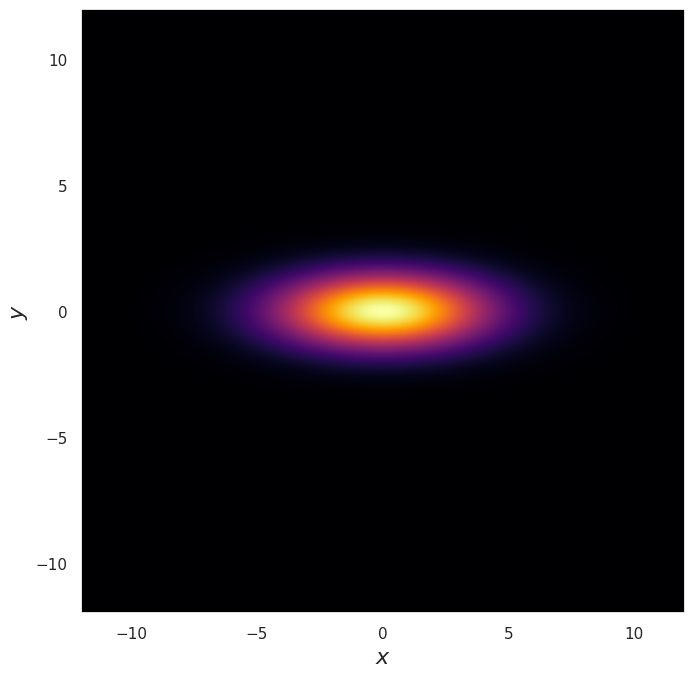

In [17]:
mu = [0,0]
cov = np.array([[4,0],
                [0,0.5]])
rot_cov = rot_matrix(cov, np.pi/2)

single_gauss = tfd.MultivariateNormalFullCovariance(
    loc=mu,
    covariance_matrix=rot_cov
)
visualize_density(single_gauss, x)

In [66]:
# @tf.function
def analytic_log_prob_grad_multi(gmm, x, sigma_i=None):
    x_tensor = tf.convert_to_tensor(x)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        if sigma_i is None:
            log_prob = tf.reduce_sum(gmm.log_prob(x_tensor))
        else:
#             sigma_i = tf.math.sqrt(sigma_i**2 + 1)
            mus = tf.convert_to_tensor(gmm.components_distribution.parameters["loc"], dtype=tf.float32)
            scales = tf.convert_to_tensor(gmm.components_distribution.parameters["covariance_matrix"], dtype=tf.float32)
            mix_probs = gmm.mixture_distribution.probs
            covs = np.identity(2)* sigma_i**2 + scales
            
            mvn = tfd.MultivariateNormalFullCovariance(
                    loc=mus,
                    covariance_matrix=covs
            )

            sigma_gmm = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=mix_probs),
                components_distribution=mvn
            )
            
            log_prob = sigma_gmm.log_prob(x_tensor)
    anal_gradients = t.gradient(log_prob, x_tensor)
    return anal_gradients

In [67]:
cross_gmm.components_distribution.parameters

{'name': 'MultivariateNormalFullCovariance',
 'allow_nan_stats': True,
 'validate_args': False,
 'covariance_matrix': <tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
 array([[[ 1.1, -0.9],
         [-0.9,  1.1]],
 
        [[ 1.1, -0.9],
         [-0.9,  1.1]]], dtype=float32)>,
 'loc': array([[-4., -4.],
        [ 4.,  4.]], dtype=float32)}

In [12]:
def visualize_density(gmm, x):
    grid = meshgrid(x)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(gmm.prob(grid), cmap='inferno', extent=[-12, 12, -12, 12], origin='lower')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
#     plt.savefig("density.pdf", bbox_inches="tight")
#     plt.colorbar()
    plt.show()
    return

def visualize_noisy_gradients(x, grads, filename="gradients"):
    cols = len(grads)
    fig, axs = plt.subplots(1, cols, figsize=(6 * cols, 6))
    axs = np.array(axs).reshape(-1)
    
    for i,ax in enumerate(axs):
        U, V = grads[i][:, :, 1], grads[i][:, :, 0]
        ax.quiver(x, x, U, V)
        
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
    
#     plt.gca().set_aspect('equal', adjustable='box')  
#     plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.show()


In [79]:
a=[]
if a:print(2)

2


In [80]:
def make_gmm(mus, covs, mix_probs=None):
    n_components = len(mus)
    
    if not mix_probs:
        mix_probs = [1/n_components]*n_components
    
    # Initialize a 2-batch of 2D Gaussians.
    mvn = tfd.MultivariateNormalFullCovariance(
        loc=mus,
        covariance_matrix=covs
    )

    gmm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=mix_probs),
        components_distribution=mvn
    )
    return gmm

In [30]:
# create a GMM (probabilities, cluster centres, cluster scales)

# define grids
x = np.linspace(-8, 8, 500, dtype=np.float32)
x_for_grads = np.linspace(-8, 8, num=20)

mus =  [[0, 0], [0, 0]]
base_cov = np.array([[4,0],
                    [0,0.25]])

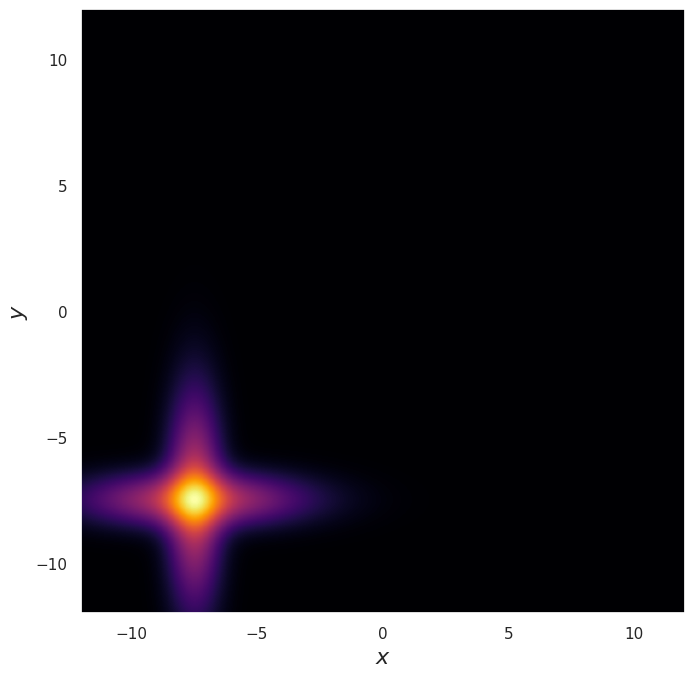

In [40]:
mus =  np.array([[-5, -5], [-5, -5]])
base_cov = np.array([[4,0],
                    [0,0.25]])

cov1 = base_cov
cov2 = rot_matrix(cov1, np.pi/2)
covs = [cov1, cov2]
covs = tf.convert_to_tensor(covs, tf.float32)

plus_gmm = make_gmm(mus, covs)
visualize_density(plus_gmm, x)

## Cross vs Plus

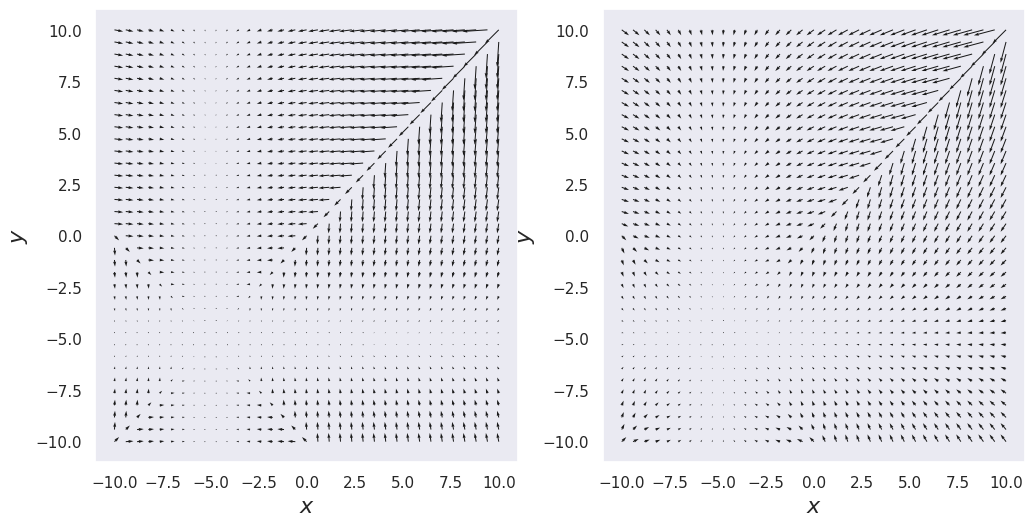

In [41]:
x_for_grads = np.linspace(-10, 10, num=35)
grid = meshgrid(x_for_grads)

# compute analytic gradients
original_grads = analytic_log_prob_grad_multi(plus_gmm, grid)
noisy_grads = analytic_log_prob_grad_multi(plus_gmm, grid, sigma_i=1.0)

# visualize gradients
visualize_noisy_gradients(x_for_grads, [original_grads, noisy_grads])

In [42]:
original_norms = tf.norm(original_grads, axis=2).numpy()
est_norms = tf.norm(noisy_grads, axis=2).numpy()

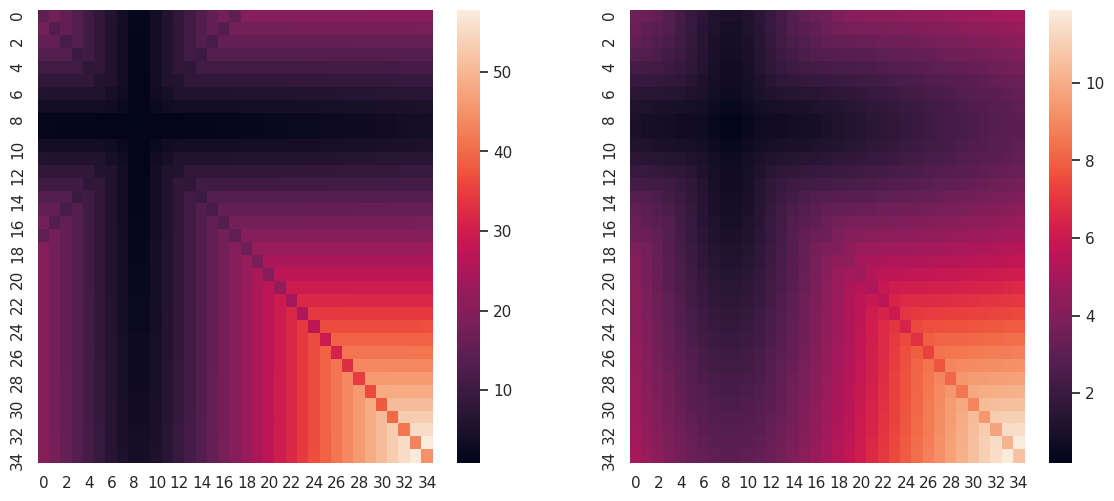

In [45]:
fig, axs = plt.subplots(1,2, figsize=(14,6))

sns.heatmap(original_norms, ax=axs[0])
sns.heatmap(est_norms, ax=axs[1])

### Cross

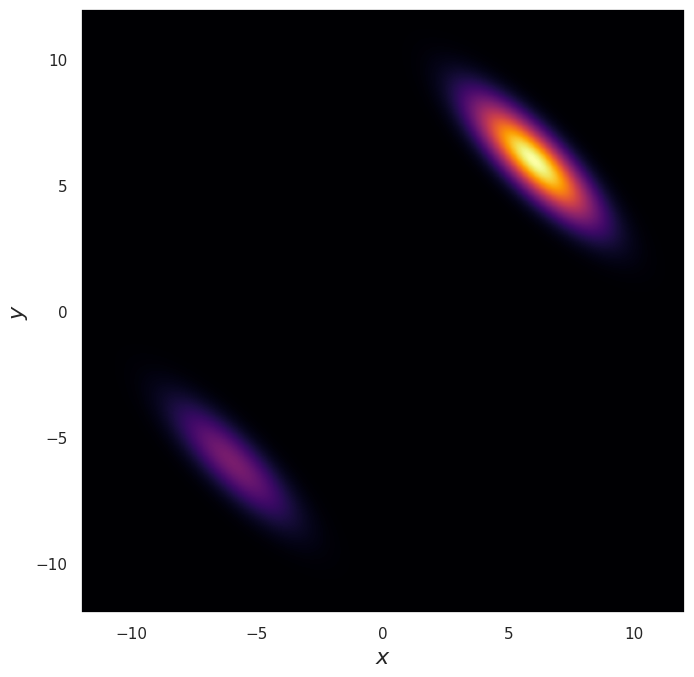

In [81]:
mus =  np.array([[-4, -4], [4, 4]], dtype=np.float32)
base_cov = np.array([[2,0],
                    [0,0.2]])


cov1 = rot_matrix(base_cov, -np.pi/4)
cov2 = rot_matrix(base_cov, -np.pi/4)
covs = [cov1, cov2]
covs = tf.convert_to_tensor(covs, tf.float32)

cross_gmm = make_gmm(mus, covs, mix_probs=[0.25, 0.75])
visualize_density(cross_gmm, x)

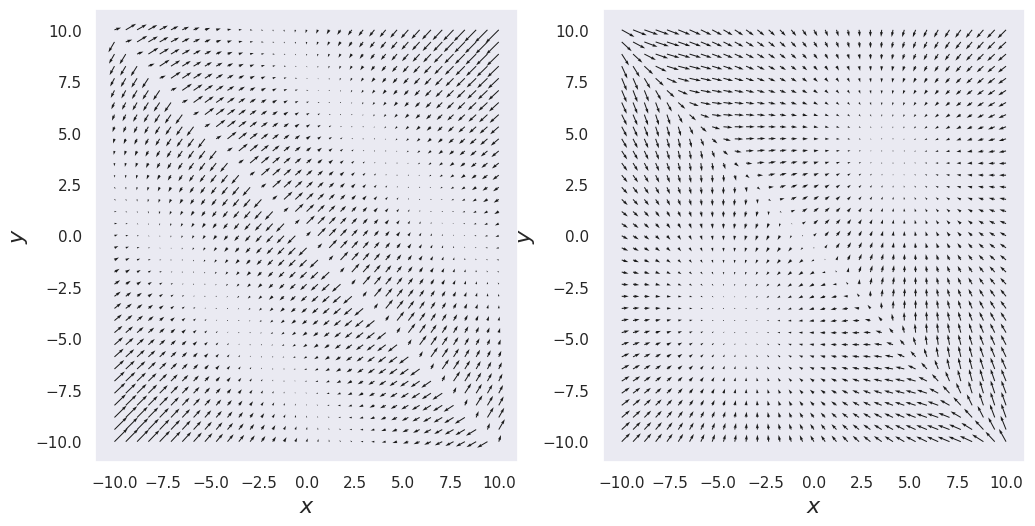

In [84]:
original_grads = analytic_log_prob_grad_multi(cross_gmm, grid)
noisy_grads = analytic_log_prob_grad_multi(cross_gmm, grid, sigma_i=2)
visualize_noisy_gradients(x_for_grads, [original_grads, noisy_grads])

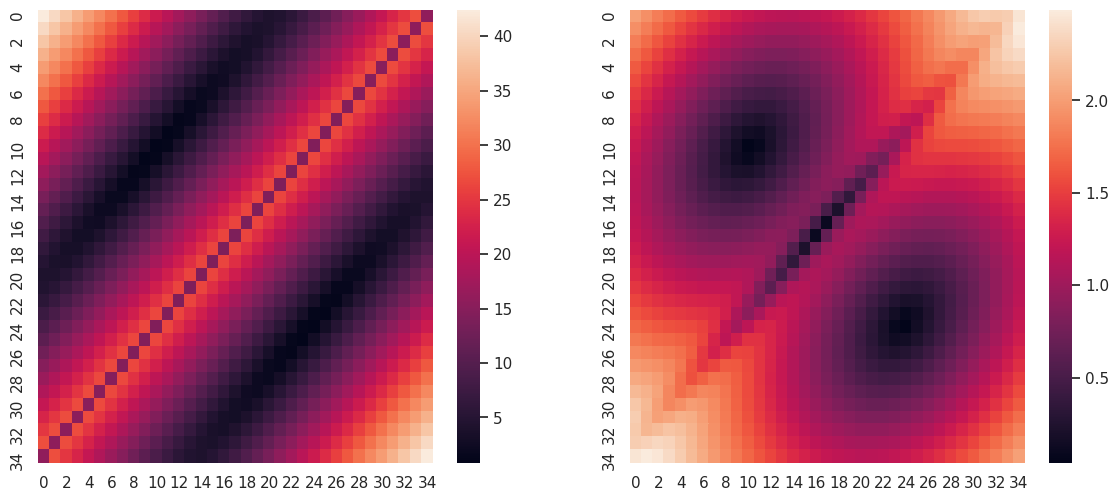

In [85]:
original_norms = tf.norm(original_grads, axis=2).numpy()
est_norms = tf.norm(noisy_grads, axis=2).numpy()

fig, axs = plt.subplots(1,2, figsize=(14,6))

sns.heatmap(original_norms, ax=axs[0])
sns.heatmap(est_norms, ax=axs[1])

In [147]:
x_for_scores = np.linspace(-10, 10, num=100)
# samples = meshgrid(x_for_scores).reshape(-1,2)
samples = np.array([(x,x) for x in x_for_scores], dtype=np.float32)

sigma_levels = tf.math.exp(tf.linspace(tf.math.log(2.0), tf.math.log(1e-1), 5))
sigma_levels = tf.linspace(2.0, 1e-1, 5)
sigma_levels

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.        , 1.525     , 1.05      , 0.57500005, 0.1       ],
      dtype=float32)>

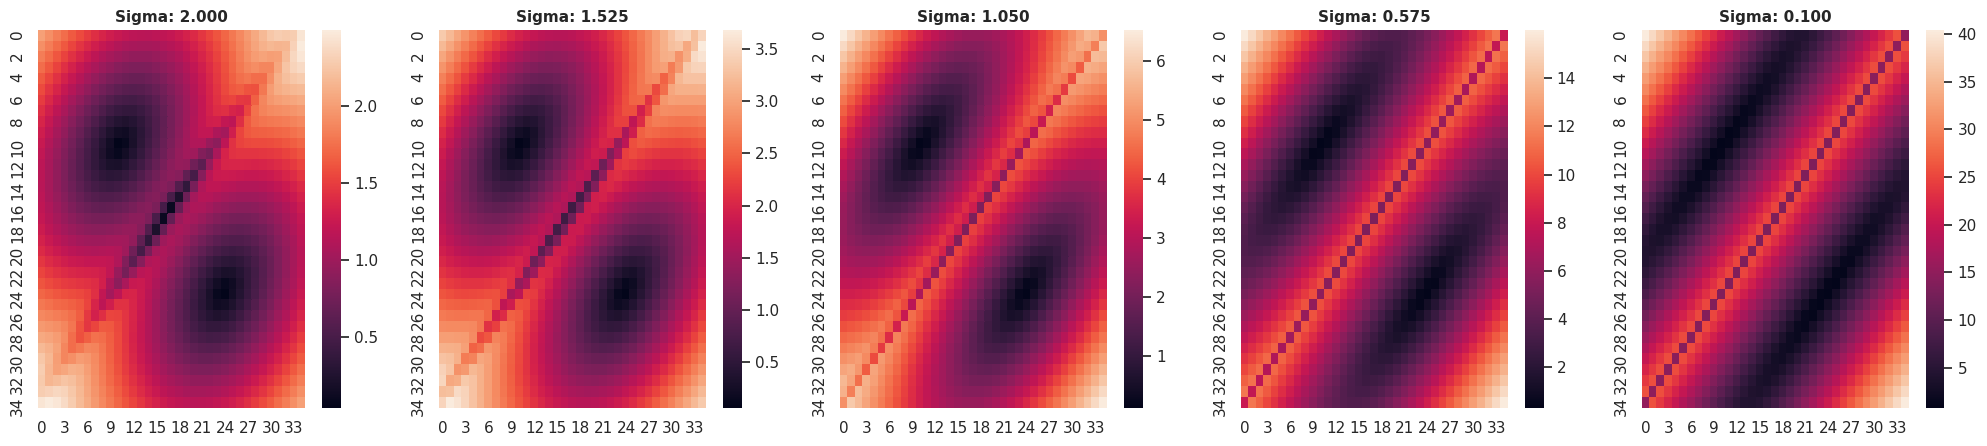

In [148]:
rows = sigma_levels.shape[0]
fig, axs = plt.subplots(1,rows, figsize=(rows*5, 5))

for i, sigma in enumerate(sigma_levels):
    noisy_grads = analytic_log_prob_grad_multi(cross_gmm, grid, sigma_i=sigma)
    est_norms = tf.norm(noisy_grads, axis=2).numpy()
    sns.heatmap(est_norms, ax=axs[i])
    axs[i].set_title("Sigma: {:.3f}".format(sigma), fontsize=11, fontweight='bold')

In [112]:
original_norms = analytic_log_prob_grad_multi(cross_gmm, samples, sigma_i=None)

In [151]:
%%time
sigma_scores = []

for sigma in sigma_levels:
    scores = analytic_log_prob_grad_multi(cross_gmm, samples, sigma_i=sigma)
    score_norms = tf.norm(scores, axis=1).numpy()
    sigma_scores.append(score_norms)

CPU times: user 94.9 ms, sys: 7.15 ms, total: 102 ms
Wall time: 98.7 ms


In [152]:
plt.close()

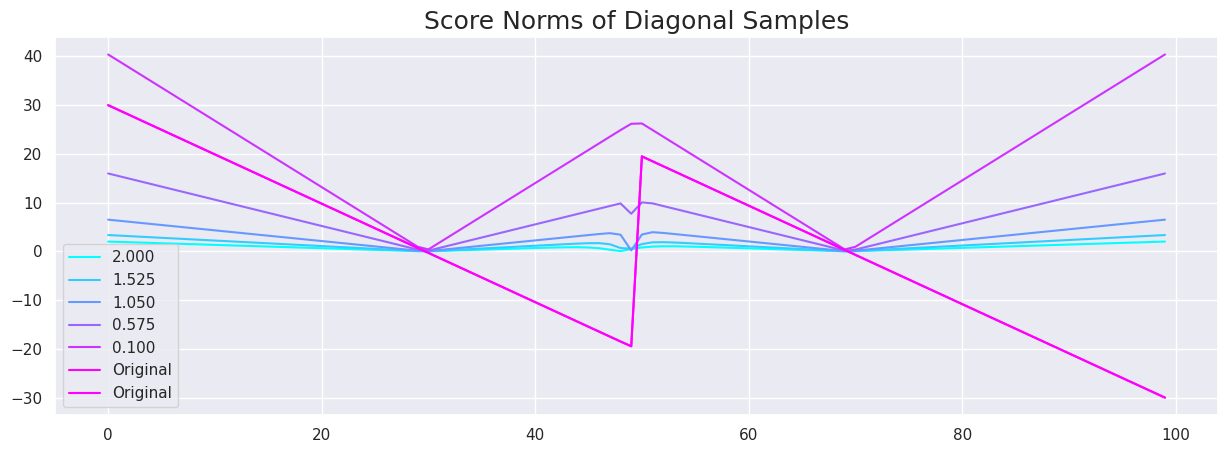

In [153]:
colors = pl.cm.cool(np.linspace(0,1, 1+sigma_levels.shape[0]))
rows = 1
fig, axs = plt.subplots(rows, 1, figsize=(15,rows*5))

for i, (sigma, norms) in enumerate(zip(sigma_levels, sigma_scores)):
    axs.plot(range(100), norms, label="{:.3f}".format(sigma), color=colors[i])

axs.plot(range(100), original_norms, label="Original", color=colors[i+1])
axs.legend()
plt.grid()
plt.title("Score Norms of Diagonal Samples")
plt.show()

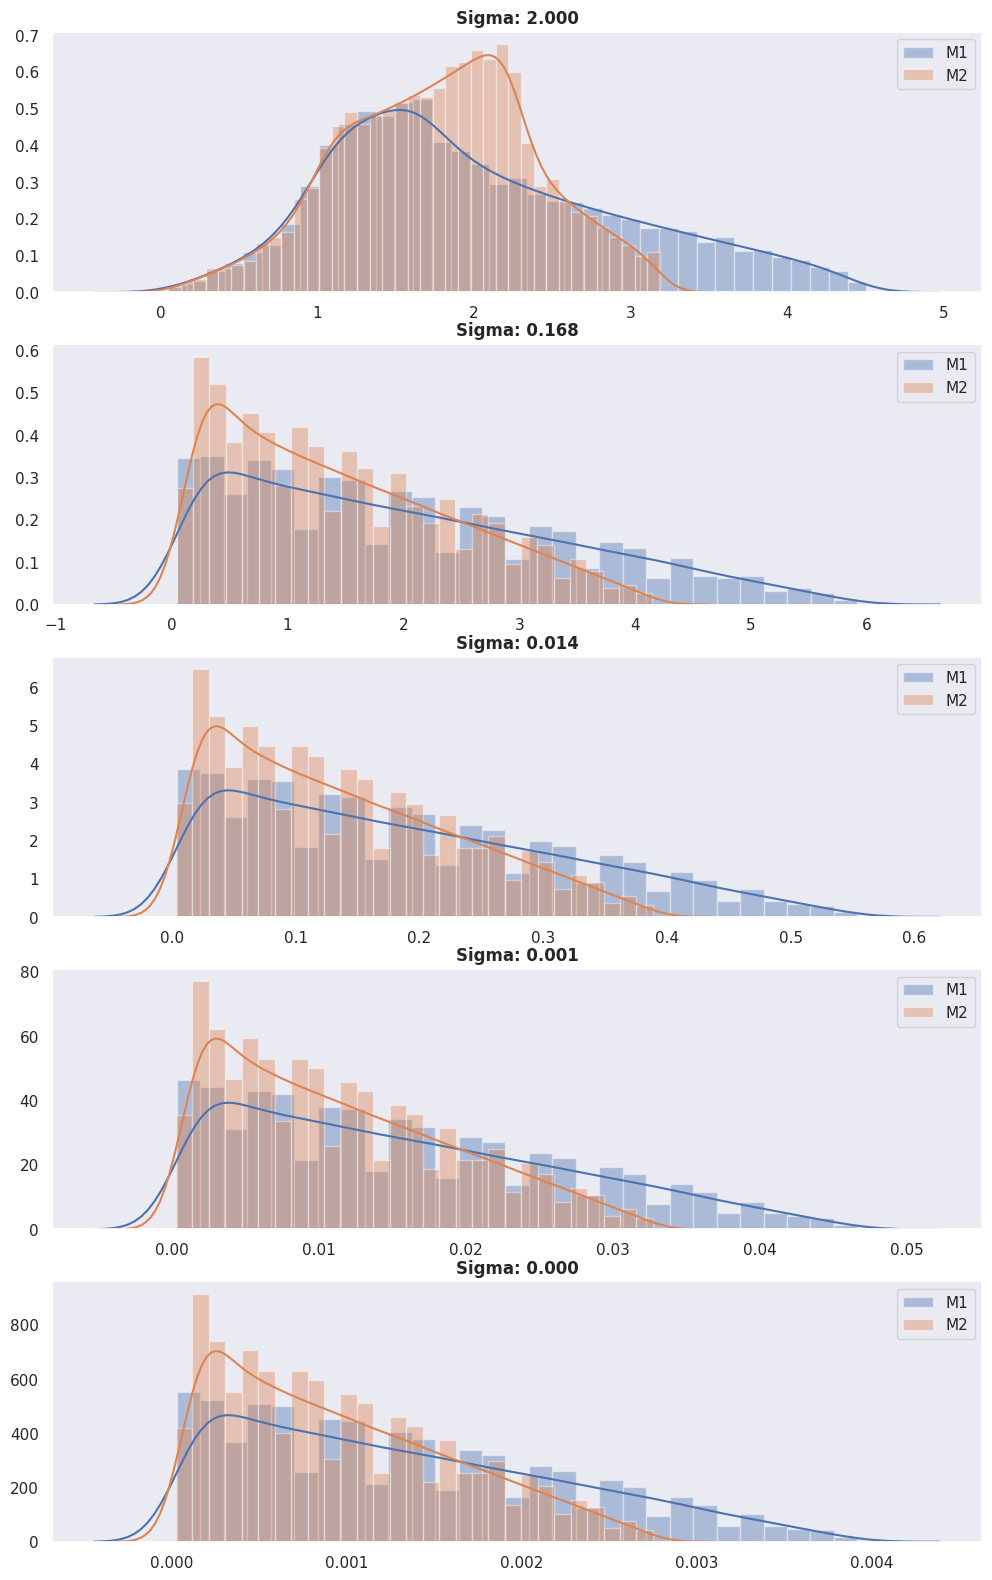

CPU times: user 2.84 s, sys: 44.7 ms, total: 2.88 s
Wall time: 2.5 s


In [956]:
%%time

sigma_scores = {}

for name, curr_gmm, curr_samples in zip(["M1", "M2"], [plus_gmm, cross_gmm], [samples, samples]):
    _scores = []

    for sigma in sigma_levels:
        score_norm = tf.norm(analytic_log_prob_grad_multi(curr_gmm, curr_samples, sigma_i=sigma),
                    axis=1)
        score_norm *= sigma
        _scores.append(score_norm)

    sigma_scores[name] = tf.stack(_scores, axis=1).numpy()

rows = sigma_levels.shape[0]
fig, axs = plt.subplots(rows, 1, figsize=(12,rows*4))
colors = sns.color_palette("bright") + sns.color_palette("dark")

for idx, sigma in enumerate(sigma_levels.numpy()):
    m2 = sigma_scores["M1"][:,idx]
    m4 = sigma_scores["M2"][:,idx]
    sns.distplot(m2, label="M1", ax=axs[idx])
    sns.distplot(m4, label="M2", ax=axs[idx])
    axs[idx].set_title("Sigma: {:.3f}".format(sigma), fontsize=12, fontweight='bold')
    axs[idx].legend()
    
plt.show()

## TODO: Moar Gaussians + Random directions

In [1007]:
# create a GMM (probabilities, cluster centres, cluster scales)

def make_plus(num_gauss=4, center=[0,0], scales=[4,2], delta=4,
              theta_range=(-np.pi/12, np.pi/12), jitter=True):
    
    probs = [1/num_gauss]*num_gauss
    
    #Spread above center should be rough 4 sd
    
    x_scales = np.array([scales[0], scales[1]])
    y_scales = np.array([scales[1], scales[0]])
    
    x_c, y_c = center
    
    # Range of mus
    x_range = [(x,0) for x in np.linspace(x_c-delta, x_c+delta, num_gauss//2)]
    y_range = [(0,y) for y in np.linspace(y_c-delta, y_c+delta, num_gauss//2)]
    
    mus = [*x_range, *y_range]
    
    if jitter:
        # Add random jitter to both loc and scales
        mus  += np.random.normal(size=(num_gauss,2)) / 10

    # Generate rotated covariance matrices wrt scales
    covs = []
    for i in range(num_gauss):
        theta = np.random.uniform(*theta_range)
        
        # First half corresponds to MVN in the x direction
        if i < num_gauss // 2:
            x_scales_jittered = x_scales + np.random.normal(size=2) / 10
            cov = np.diagflat(x_scales_jittered)
            
        else:
            cov = np.diagflat(y_scales)
        
        # To make positive semidefinite
        cov = cov @ cov.T
        cov = rot_matrix(cov, theta)
        covs.append(cov)
    
    covs = tf.convert_to_tensor(covs, dtype=tf.float32)
    mus = tf.convert_to_tensor(mus, dtype=tf.float32)
    

    
#     print(covs)
#     print(mus)
    
    mvn = tfd.MultivariateNormalFullCovariance(
        loc=mus,
        covariance_matrix=covs
    )
    
    gmm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=probs),
        components_distribution=mvn
    )
    
    return gmm

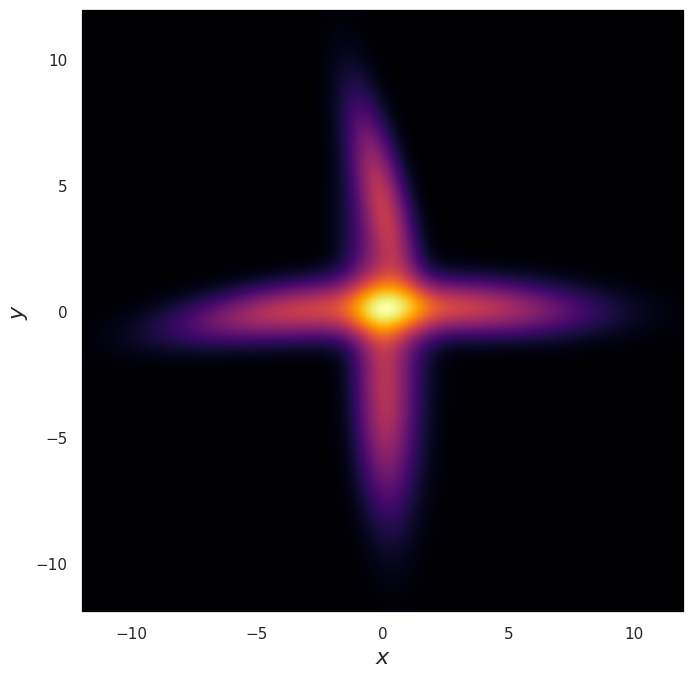

In [1008]:
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

m6_gmm = make_plus(num_gauss=6, center=[0,0], scales=[2,1/2], delta=3, jitter=False)

# define grids
x = np.linspace(-8, 8, 500, dtype=np.float32)

# plot density
visualize_density(m6_gmm, x)

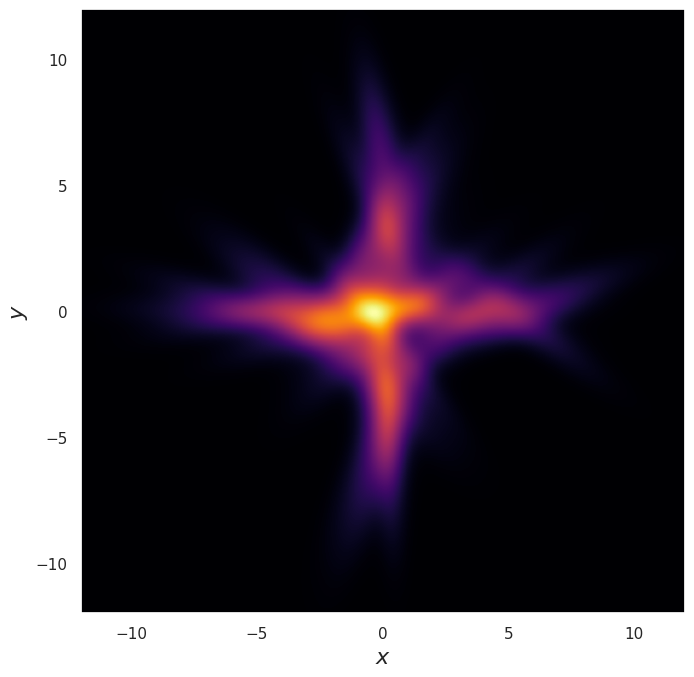

In [1013]:
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

m4_gmm = make_plus(num_gauss=32, center=[0,0], scales=[1.75,1/3], delta=4,
                   theta_range=(-np.pi/4, np.pi/4))

visualize_density(m4_gmm, x)

In [ ]:
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

m4_gmm = make_plus(num_gauss=32, center=[0,0], scales=[1.75,1/3], delta=4,
                   theta_range=(-np.pi/4, np.pi/4))

visualize_density(m4_gmm, x)

## Score Norms

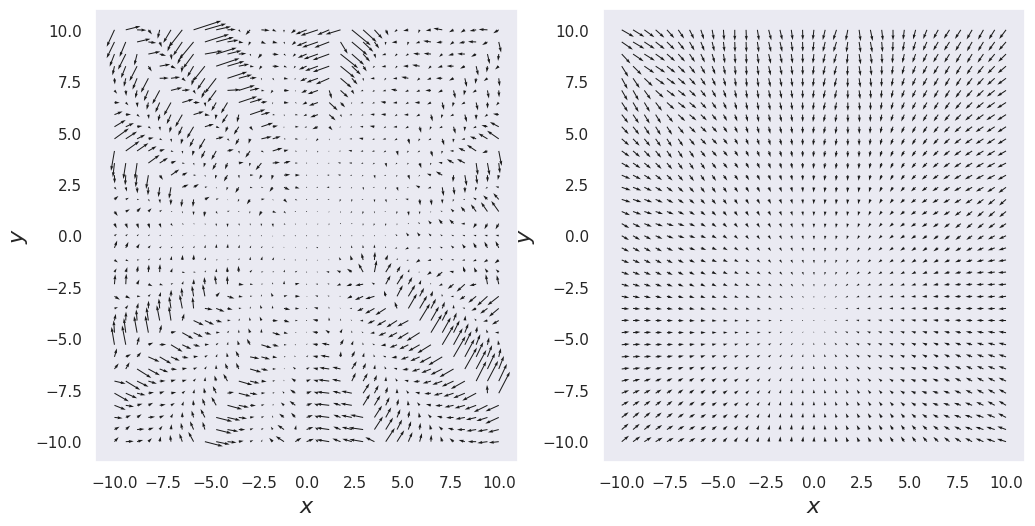

In [1020]:
x_for_grads = np.linspace(-10, 10, num=35)
grid = meshgrid(x_for_grads)

# compute analytic gradients
original_grads = analytic_log_prob_grad_multi(m4_gmm, grid)
noisy_grads = analytic_log_prob_grad_multi(m4_gmm, grid, sigma_i=1.0)

# visualize gradients
visualize_noisy_gradients(x_for_grads, [original_grads, noisy_grads])

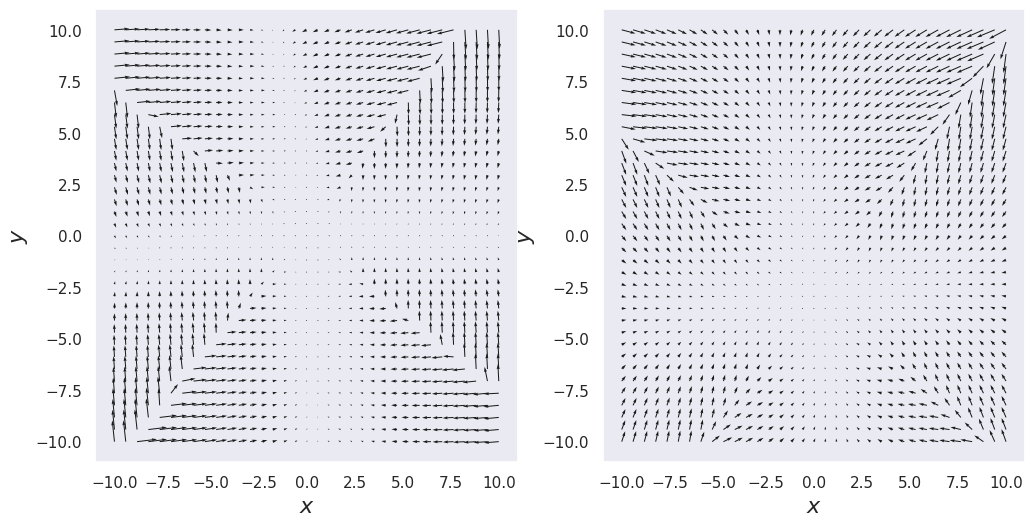

In [1015]:
original_grads = analytic_log_prob_grad_multi(m6_gmm, grid)
noisy_grads = analytic_log_prob_grad_multi(m6_gmm, grid, sigma_i=1.0)
visualize_noisy_gradients(x_for_grads, [original_grads, noisy_grads])

## Comparing scores w/ low sigmas

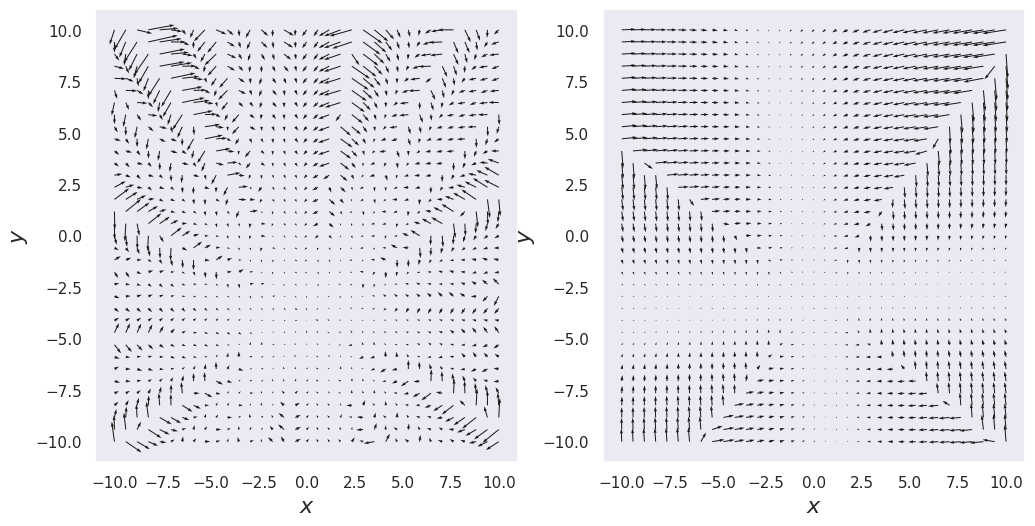

In [1016]:
m1_grads = analytic_log_prob_grad_multi(m4_gmm, grid, sigma_i=0.001)
m2_grads = analytic_log_prob_grad_multi(m6_gmm, grid, sigma_i=0.001)
visualize_noisy_gradients(x_for_grads, [m1_grads, m2_grads])

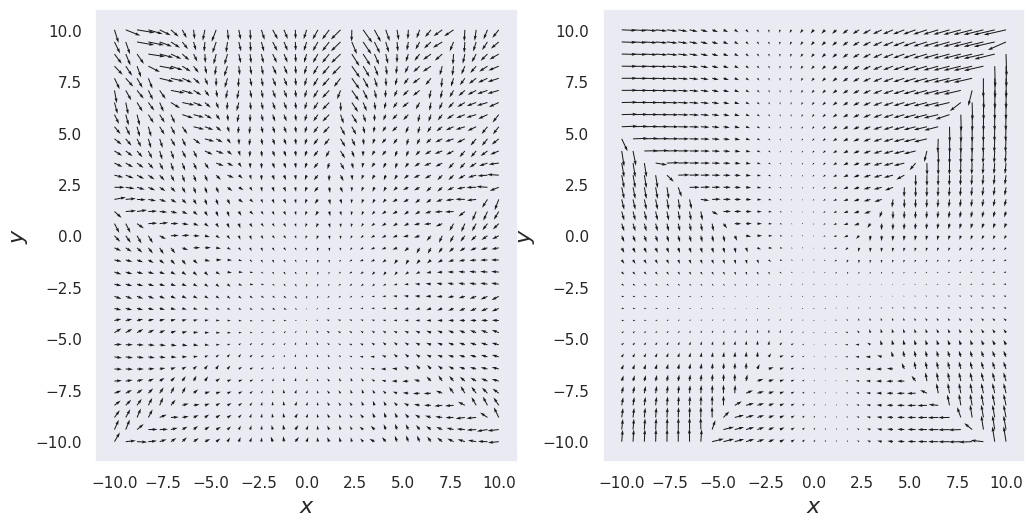

In [1023]:
m1_grads = analytic_log_prob_grad_multi(m4_gmm, grid, sigma_i=0.5)
m2_grads = analytic_log_prob_grad_multi(m6_gmm, grid, sigma_i=0.5)
visualize_noisy_gradients(x_for_grads, [m1_grads, m2_grads])

In [1028]:
x_for_scores = np.linspace(-10, 10, num=100)
samples = meshgrid(x_for_scores).reshape(-1,2)

sigma_levels = tf.math.exp(tf.linspace(tf.math.log(2.0), tf.math.log(1e-3), 5))
# sigma_levels = tf.linspace(2.0, 1e-1, 5)
sigma_levels

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.0000000e+00, 2.9906976e-01, 4.4721358e-02, 6.6874027e-03,
       9.9999993e-04], dtype=float32)>

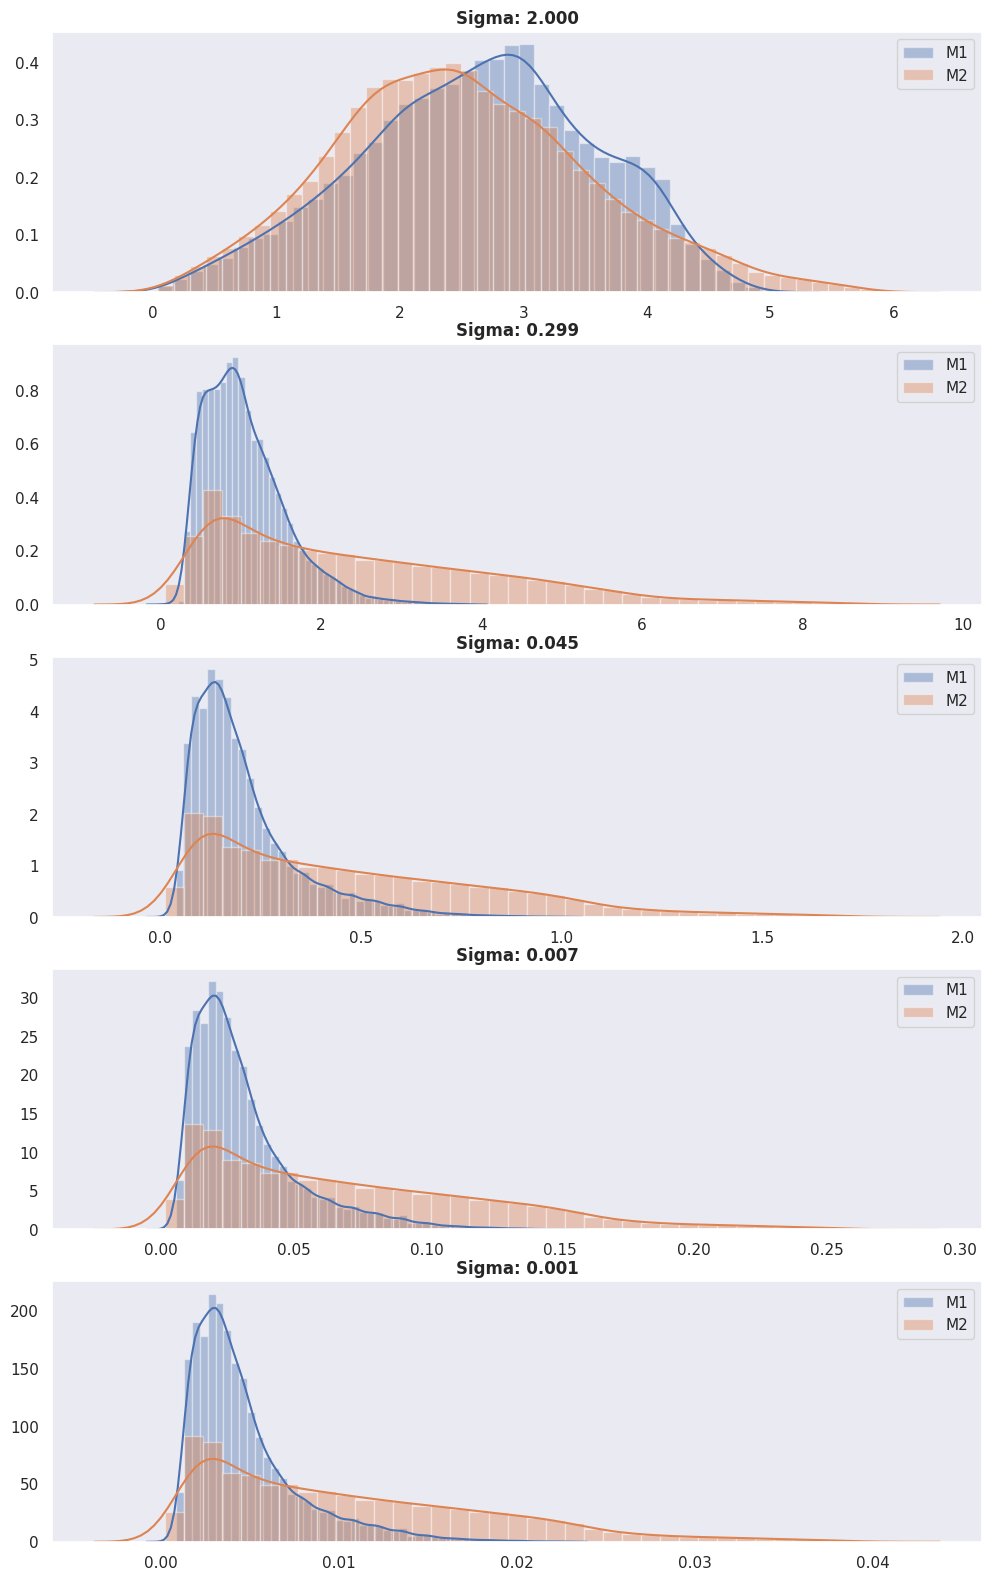

CPU times: user 9.12 s, sys: 392 ms, total: 9.51 s
Wall time: 3.09 s


In [1031]:
%%time

sigma_scores = {}

for name, curr_gmm, curr_samples in zip(["M1", "M2"], [m4_gmm, m6_gmm], [samples, samples]):
    _scores = []

    for sigma in sigma_levels:
        score_norm = tf.norm(analytic_log_prob_grad_multi(curr_gmm, curr_samples, sigma_i=sigma),
                    axis=1)
        score_norm *= sigma
        _scores.append(score_norm)

    sigma_scores[name] = tf.stack(_scores, axis=1).numpy()

rows = sigma_levels.shape[0]
fig, axs = plt.subplots(rows, 1, figsize=(12,rows*4))
colors = sns.color_palette("bright") + sns.color_palette("dark")

for idx, sigma in enumerate(sigma_levels.numpy()):
    m2 = sigma_scores["M1"][:,idx]
    m4 = sigma_scores["M2"][:,idx]
    sns.distplot(m2, label="M1", ax=axs[idx], kde=True)
    sns.distplot(m4, label="M2", ax=axs[idx], kde=True)
    axs[idx].set_title("Sigma: {:.3f}".format(sigma), fontsize=12, fontweight='bold')
    axs[idx].legend()
    
plt.show()

## M4 samples wrt M2

In [312]:
%%time

sigma_scores = {}

for name, curr_gmm, curr_samples in zip(["M2", "M4"], [m2_gmm, m2_gmm], [m2_samples, m4_samples]):
    _scores = []

    for sigma in sigma_levels:
        score_norm = tf.norm(analytic_log_prob_grad_multi(curr_gmm, curr_samples, sigma_i=sigma),
                    axis=1)
        score_norm *= sigma
        _scores.append(score_norm)

    sigma_scores[name] = tf.stack(_scores, axis=1).numpy()

CPU times: user 426 ms, sys: 6.92 ms, total: 433 ms
Wall time: 425 ms


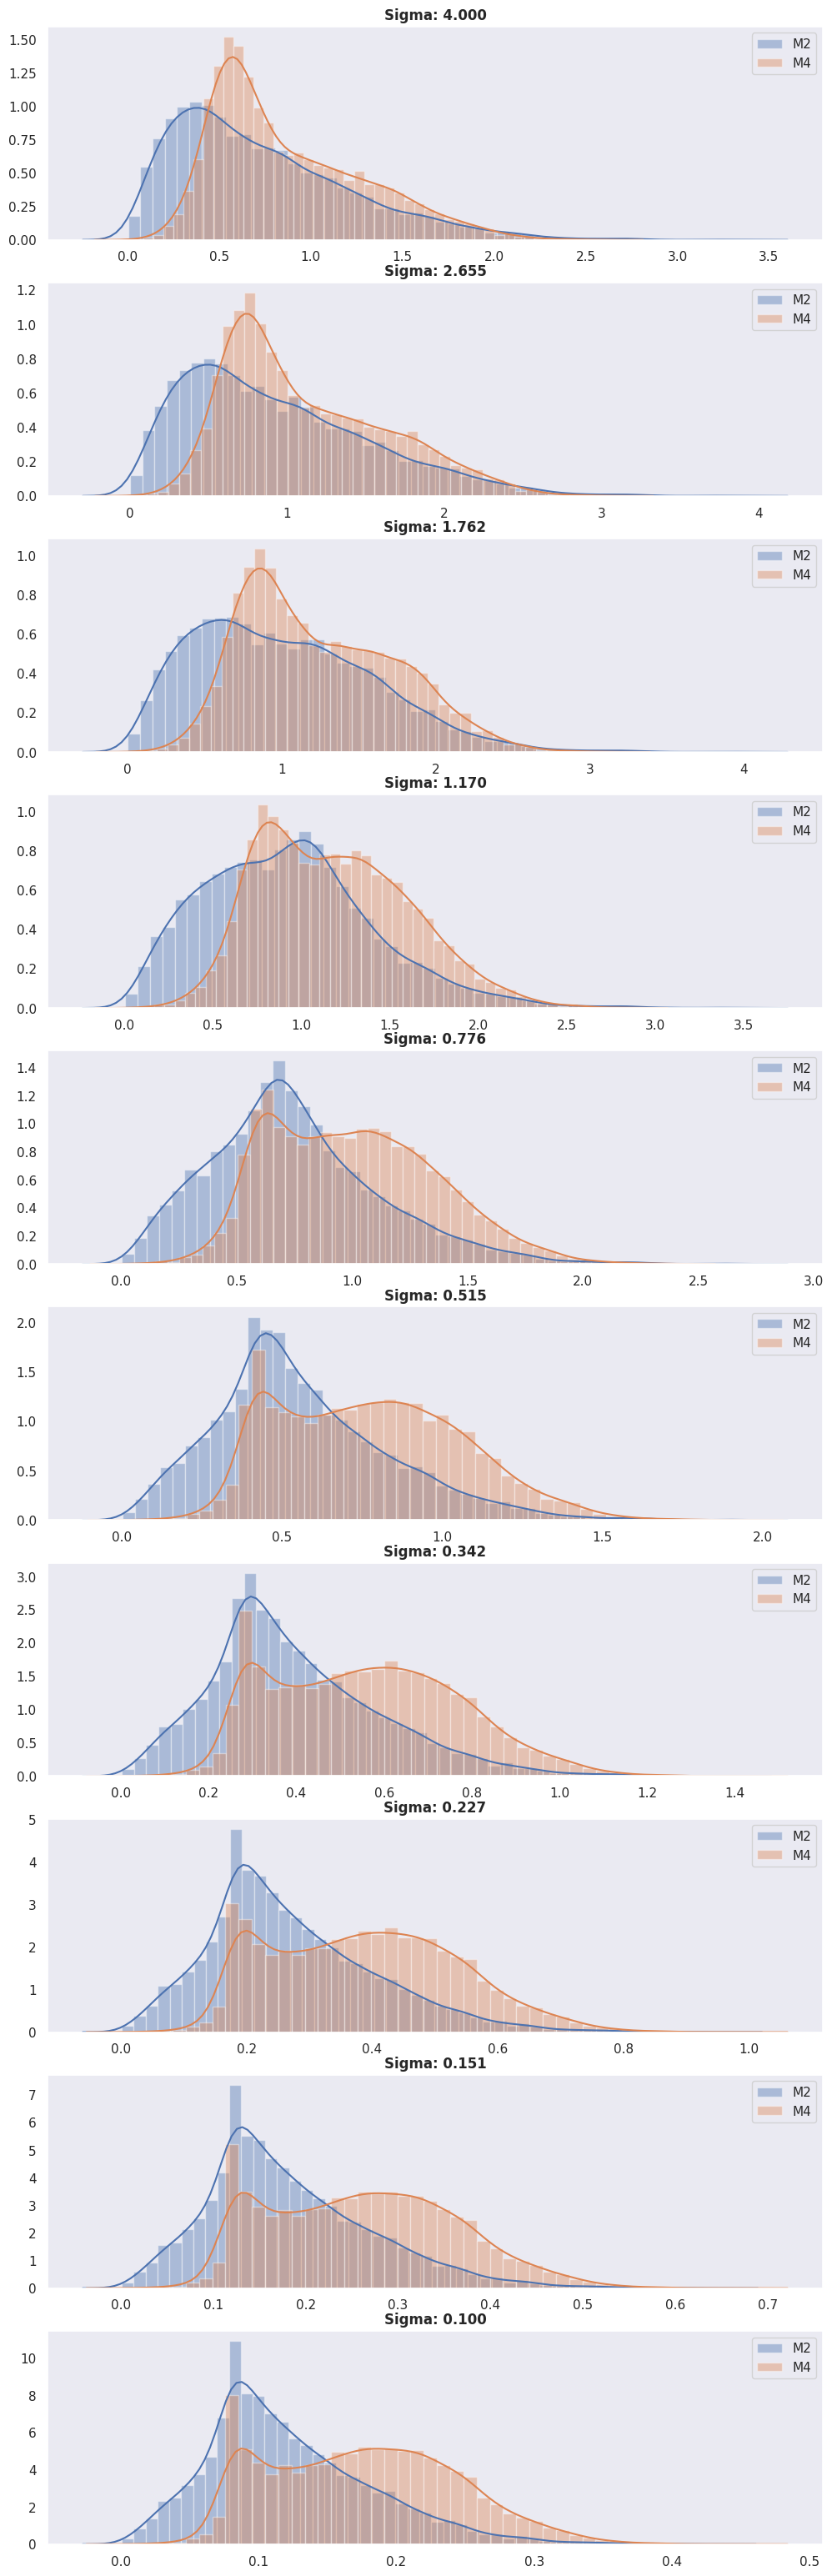

In [313]:
rows = 10
fig, axs = plt.subplots(rows, 1, figsize=(12,rows*4))
colors = sns.color_palette("bright") + sns.color_palette("dark")

for idx, sigma in enumerate(sigma_levels.numpy()):
    m2 = sigma_scores["M2"][:,idx]
    m4 = sigma_scores["M4"][:,idx]
    sns.distplot(m2, label="M2", ax=axs[idx])
    sns.distplot(m4, label="M4", ax=axs[idx])
    axs[idx].set_title("Sigma: {:.3f}".format(sigma), fontsize=12, fontweight='bold')
    axs[idx].legend()
    
plt.show()

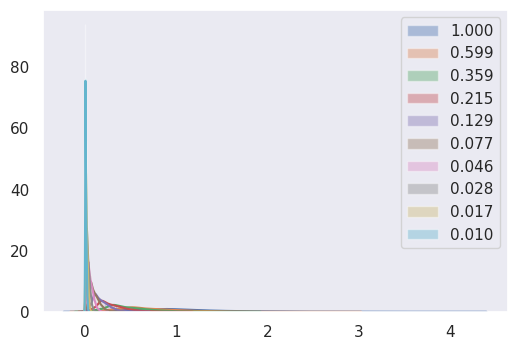

CPU times: user 1.91 s, sys: 26.6 ms, total: 1.94 s
Wall time: 1.93 s


In [241]:
%%time

_scores = []

for sigma in sigma_levels:
    score_norm = tf.norm(analytic_log_prob_grad_multi(m2_gmm, m4_samples, sigma_i=sigma),
                axis=1)
    score_norm *= sigma
    _scores.append(score_norm)

m4_scores_sigma = tf.stack(_scores, axis=1).numpy()

for idx, sigma in enumerate(sigma_levels.numpy()[:]):
    sns.distplot(m4_scores_sigma[:,idx], label="{:.3f}".format(sigma))
plt.legend()
plt.show()

In [ ]:
##Compare side by side plots of both scores

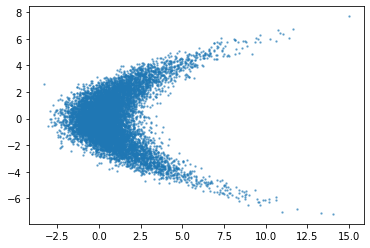

In [71]:
# Generate data
n = 10000
x3 = np.random.poisson(lam=1,size=n).astype(dtype=np.float32) * 2.
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2, x3], axis=-1)
plt.scatter(x1,x2, alpha=0.5, s=2)

In [73]:
(x2 * x2).shape

(10000,)

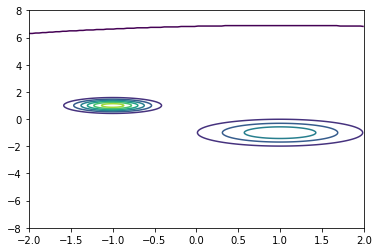

In [82]:
### Create a mixture of two Bivariate Gaussians:

gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[[-1., 1],  # component 1
             [1, -1]],  # component 2
        scale_identity_multiplier=[.3, .6]))

gm.mean()
# ==> array([ 0.4, -0.4], dtype=float32)

gm.covariance()
# ==> array([[ 1.119, -0.84],
#            [-0.84,  1.119]], dtype=float32)

# Plot PDF contours.
def meshgrid(x, y=x):
  [gx, gy] = np.meshgrid(x, y, indexing='ij')
  gx, gy = np.float32(gx), np.float32(gy)
  grid = np.concatenate([gx.ravel()[None, :], gy.ravel()[None, :]], axis=0)
  return grid.T.reshape(x.size, y.size, 2)
grid = meshgrid(np.linspace(-2, 2, 100, dtype=np.float32))
plt.contour(grid[..., 0], grid[..., 1], gm.prob(grid).numpy());